# Import et fonctions utilitaires

In [11]:
from PC import PC
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn_vs_bn as bn_vs_bn
import time
import itertools
import random
import matplotlib.pyplot as plt

#Fonction qui permet la création de tous les BN possibles étant donné un graphe essentiel
def get_approxBN(bn,AlgoPC:PC):
    """
    - Si PC rend un graphe mixte (un graphe essentiel, i.e. classe d'équivalence de markov): construit une liste de BN possibles
    - Si PC rend un DAG : construit le BN avec la même structure

    Parameters
    ----------
    AlgoPC : PC
        l'objet associé à l'apprentissage

    Returns
    -------
    liste de pyAgrum.BayesNet ou un pyAgrum.BayesNet
        le/les BN associé
    """
    nb_BN=2**len(AlgoPC.G.edges()) #le nombre de BN possibles dépend du nombre d'arretes dans la classe d'équivalence de Markov
    bn_approx_base=gum.BayesNet('bn_approx_base')
    allApproxBn=[]
    for nodeID in AlgoPC.G.nodes():
        bn_approx_base.add(gum.LabelizedVariable(bn.variable(nodeID).name(),''))
    for (node1,node2) in AlgoPC.G.arcs():
        try :
            bn_approx_base.addArc(bn.variable(node1).name(),bn.variable(node2).name())
        except:
            print("CYCLE DANS UN DAG !")
            # gnb.sideBySide(GPhase1,GPhase21,GPhase2)
            # print(AlgoPC.verbose)
            raise
            return []
    if(len(AlgoPC.G.edges())!=0): #Si G a des arêtes
        allApproxBn=[gum.BayesNet(bn_approx_base) for _ in range(nb_BN)]
        permutations=[]
        for node1,node2 in AlgoPC.G.edges():
            permutations+=list(itertools.permutations((node1,node2))) 
        combinations=list(itertools.combinations(permutations,len(AlgoPC.G.edges())))
        l=[]
        for comb in combinations:
            hasRemoved=False
            for i in range(0,len(comb)-1):
                for j in range(i+1,len(comb)):
                    if( set(comb[i])==set(comb[j])):
                        l.append(comb)
                        hasRemoved=True
                        break
                if(hasRemoved):
                    break
        for comb in l:
            combinations.remove(comb)
        for (bn_i,comb) in zip(allApproxBn,combinations):
            for node1,node2 in comb:
                try:
                    bn_i.addArc(bn.variable(node1).name(),bn.variable(node2).name())
                except:
                    bn_i.addArc(bn.variable(node2).name(),bn.variable(node1).name())
    else : #Si G est un DAG
        allApproxBn.append(bn_approx_base)
    return allApproxBn
#Fonction qui permet la création d'un des BN possibles étant donné un graphe essentiel
def getOneApproxBN(bn,AlgoPC:PC):
    bn_approx=gum.BayesNet('bn_approx_base')
    for nodeID in AlgoPC.G.nodes():
        bn_approx.add(gum.LabelizedVariable(bn.variable(nodeID).name(),''))
    for (node1,node2) in AlgoPC.G.arcs():
        bn_approx.addArc(bn.variable(node1).name(),bn.variable(node2).name())
    for node1,node2 in AlgoPC.G.edges():
        try:
            bn_approx.addArc(bn.variable(node1).name(),bn.variable(node2).name())
        except:
            bn_approx.addArc(bn.variable(node2).name(),bn.variable(node1).name())
    return bn_approx

# 1. Algorithme PC

In [12]:
#Générer un BN aléatoire
def genRandomBN(n=20000,n_nodes=5, n_arcs=8, n_modmax=4,name_out="test.csv"):
    generator=gum.BNGenerator()
    bn=generator.generate(n_nodes, n_arcs, n_modmax)
    gum.generateCSV(bn,name_out, n, show_progress=False, with_labels=False)
    return bn

#Fonction d'apprentissage avec PC, retourne tous les BN issus du graphe essentiel
def learn_PC(bn,csvFilePath="test.csv",verbose=False,isTest=False,nivRisque=0.05):
    """Approxime un BN à partir de particules données à travers un CSV donné.

    Parameters
    ----------
    csvFilePath : str, optional
        chemin vers le fichier CSV, by default "test.csv"
    verbose : bool, optional
        Permet d'afficher le graphe mixte au cours de l'apprentissage et le BN approximé à la fin avec le BN utilisé pour 
        générer les particules, by default False

    Returns
    -------
    pyAgrum.BayesNet
        Une approximation du BN qui a généré les particules
    """
    start=time.time()
    AlgoPC=PC(csvFilePath=csvFilePath)
    if verbose:
        print("######################## Apprentissage avec PC ########################\n")
        GNonOriente=gum.MixedGraph(AlgoPC.G)
    #GNonOriente=gum.MixedGraph(AlgoPC.G)

    AlgoPC.phase1(nivRisque=nivRisque)
    if verbose:
        GPhase1=gum.MixedGraph(AlgoPC.G)
    #GPhase1=gum.MixedGraph(AlgoPC.G)
    AlgoPC.phase2()
    end=time.time()
    duration=end-start
    
    if (not isTest):
        all_bnApprox=get_approxBN(bn,AlgoPC)
    if (isTest):
        oneBN=getOneApproxBN(bn,AlgoPC)

    if verbose:
        GPhase21=AlgoPC.GPhase21
        GPhase2=gum.MixedGraph(AlgoPC.G)
        s='s' if duration>1 else ""
        print(f"Apprentissage en {duration} seconde{s} avec {AlgoPC.learner.nbRows()} particules générées à partir d'un BN avec {len(bn.nodes())} noeuds, {len(bn.arcs())} arcs et de modalité maximum {bn.maxVarDomainSize()} ")
        print("Graphe 1 : non orienté complet ------ Graphe 2 : après phase 1 ------ Graphe 3 : après phase 2.1 ------ Graphe 4 : après phase 2.2")
        gnb.sideBySide(GNonOriente,GPhase1,GPhase21,GPhase2)
        if(not isTest):
            print("1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC")
            gnb.sideBySide(bn,*all_bnApprox)
        if (isTest):
            print("1er BN = BN utilisé pour générer les particules ------ 2ème BN = un des BN possibles issus du graphe essentiel")
            gnb.sideBySide(bn,oneBN)
    if (not isTest):
        return all_bnApprox,duration,AlgoPC
    if (isTest):
        return oneBN,duration,AlgoPC

## 1.1 Exemple d'utilisation

In [26]:
############Exemple############
bn=genRandomBN()
bn_approx,duration,_=learn_PC(bn,csvFilePath="test.csv",verbose=True)

######################## Apprentissage avec PC ########################

Apprentissage en 0.03858375549316406 seconde avec 20000 particules générées à partir d'un BN avec 5 noeuds, 6 arcs et de modalité maximum 4 
Graphe 1 : non orienté complet ------ Graphe 2 : après phase 1 ------ Graphe 3 : après phase 2.1 ------ Graphe 4 : après phase 2.2


no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 1->2 --> 1->2 <!-- 1->3 --> 1->3 <!-- 1->4 --> 1->4 <!-- 2->3 --> 2->3 <!-- 2->4 --> 2->4 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 1->3 --> 1->3 <!-- 4 --> 4 4 <!-- 2->4 --> 2->4 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 1->3 --> 1->3 <!-- 4 --> 4 4 <!-- 4->2 --> 4->2 <!-- 4->3 --> 4->3,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 1->3 --> 1->3 <!-- 4 --> 4 4 <!-- 4->2 --> 4->2 <!-- 4->3 --> 4->3


1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC


G <!-- n_3 --> n_3 n_3 <!-- n_1 --> n_1 n_1 <!-- n_3->n_1 --> n_3->n_1 <!-- n_0 --> n_0 n_0 <!-- n_0->n_3 --> n_0->n_3 <!-- n_2 --> n_2 n_2 <!-- n_0->n_2 --> n_0->n_2 <!-- n_0->n_1 --> n_0->n_1 <!-- n_4 --> n_4 n_4 <!-- n_4->n_3 --> n_4->n_3 <!-- n_4->n_2 --> n_4->n_2,G <!-- n_3 --> n_3 n_3 <!-- n_0 --> n_0 n_0 <!-- n_0->n_3 --> n_0->n_3 <!-- n_2 --> n_2 n_2 <!-- n_0->n_2 --> n_0->n_2 <!-- n_1 --> n_1 n_1 <!-- n_0->n_1 --> n_0->n_1 <!-- n_4 --> n_4 n_4 <!-- n_4->n_3 --> n_4->n_3 <!-- n_4->n_2 --> n_4->n_2 <!-- n_1->n_3 --> n_1->n_3,G <!-- n_3 --> n_3 n_3 <!-- n_0 --> n_0 n_0 <!-- n_0->n_3 --> n_0->n_3 <!-- n_2 --> n_2 n_2 <!-- n_0->n_2 --> n_0->n_2 <!-- n_4 --> n_4 n_4 <!-- n_4->n_3 --> n_4->n_3 <!-- n_4->n_2 --> n_4->n_2 <!-- n_1 --> n_1 n_1 <!-- n_1->n_3 --> n_1->n_3 <!-- n_1->n_0 --> n_1->n_0


## 1.2 Analyse Expérimentale de PC

### 1.2.1 Test du temps d'execution moyen pour des BN en fonction du nombre de particules dans le CSV
- n_nodes = entier entre 5 et 10
- n_arcs=1.25*n_nodes

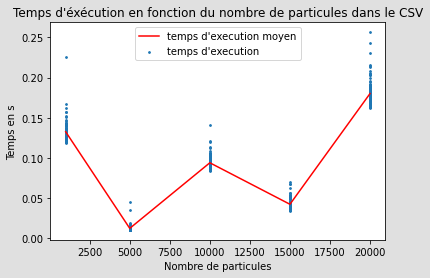

In [9]:
def testTempsExec_EnFonction_NbParticules(Algo):   
    #On teste l'algorithme quand le nombre de particules est de 1000, 5000, 10000, 15000 ou 20000
    list_nb_particules=[1000,5000,10000,15000,20000]
    #On fait 100 expériences pour chaque nombre de particules
    nb_apprentissage_par_n=100

    criteres_all=[]
    #Pour chaque nombre de particules
    for n in list_nb_particules:
        #Génerer le nombre de noeuds/arcs aléatoirement entre 5 et 10
        n_nodes=random.randint(5,10)
        n_arcs=int(n_nodes*1.25)
        #Génerer le BN aléatoirement et le CSV
        bn=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
        #On créer un nombre nb_apprentissage_par_n de BN
        for _ in range(nb_apprentissage_par_n):
            #Appel de PC
            _,duration,_=Algo(bn,csvFilePath="test.csv",verbose=False,isTest=True)
            criteres=dict()
            criteres["duration"]=duration
            criteres["nb_particule"]=n
            criteres_all.append(criteres)
    #Calcul du temps moyen pour chaque nombre de particules 
    bnx=[criteres["nb_particule"] for criteres in criteres_all]
    bny=[criteres["duration"] for criteres in criteres_all]
    list_moy_selon_nb_particules=[]
    for n in list_nb_particules:
        moy=0
        i=0
        for criteres in criteres_all:
            if(criteres["nb_particule"]==n):
                moy+=criteres["duration"]
                i+=1
        list_moy_selon_nb_particules.append(moy/i)
    return bnx,bny,list_nb_particules,list_moy_selon_nb_particules
def plot_testTempsExec_EnFonction_NbParticules(bnx,bny,list_nb_particules,list_moy_selon_nb_particules):
    #Plot nombre particules/ Temps en s d'execution
    scat=plt.scatter(bnx,bny,label="temps d'execution",s=3)
    line=plt.plot(list_nb_particules,list_moy_selon_nb_particules,c='r',label="temps d'execution moyen")
    plt.title("Temps d'éxécution en fonction du nombre de particules dans le CSV")
    plt.xlabel("Nombre de particules")
    plt.ylabel("Temps en s")
    plt.legend()
    plt.show()

plot_testTempsExec_EnFonction_NbParticules(*testTempsExec_EnFonction_NbParticules(learn_PC))

### 1.2.2 Test du temps d'execution moyen pour des BN en fonction du nombre noeuds dans le BN
- CSV = 5000 particules
- nb_arcs=1.25*nb_noeuds

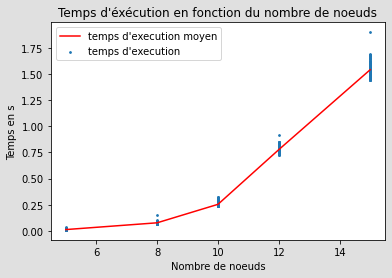

In [41]:
def testTempsExec_enFonction_nbNoeuds(Algo):
    nb_apprentissage_par_n_nodes=100
    criteres_all=[]
    list_nb_nodes=[5,8,10,12,15]
    n=5000

    for n_nodes in list_nb_nodes:
        n_arcs=int(1.25*n_nodes)
        bn=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
        for _ in range(nb_apprentissage_par_n_nodes):
            criteres=dict()
            _,duration,_=Algo(bn,csvFilePath="test.csv",verbose=False,isTest=True)
            criteres_all.append(criteres)
            criteres["duration"]=duration
            criteres["n_nodes"]=n_nodes
    bnx=[criteres["n_nodes"] for criteres in criteres_all]
    bny=[criteres["duration"] for criteres in criteres_all]
    list_moy_selon_nb_nodes=[]
    for n in list_nb_nodes:
        moy=0
        i=0
        for criteres in criteres_all:
            if(criteres["n_nodes"]==n):
                moy+=criteres["duration"]
                i+=1
        list_moy_selon_nb_nodes.append(moy/i)
    return bnx,bny,list_nb_nodes,list_moy_selon_nb_nodes

def plot_testTempsExec_enFonction_nbNoeuds(bnx,bny,list_nb_nodes,list_moy_selon_nb_nodes):
    #Plot nombre particules/ Temps en s d'execution
    scat=plt.scatter(bnx,bny,label="temps d'execution",s=3)
    line=plt.plot(list_nb_nodes,list_moy_selon_nb_nodes,c='r',label="temps d'execution moyen")
    plt.title("Temps d'éxécution en fonction du nombre de noeuds")
    plt.xlabel("Nombre de noeuds")
    plt.ylabel("Temps en s")
    plt.legend()
    plt.show()

plot_testTempsExec_enFonction_nbNoeuds(*testTempsExec_enFonction_nbNoeuds(learn_PC))

### 1.2.3 Test Structural Hamming, F-score, dist2opt en fonction du nombre de noeuds dans un BN
- CSV = 5000 particules

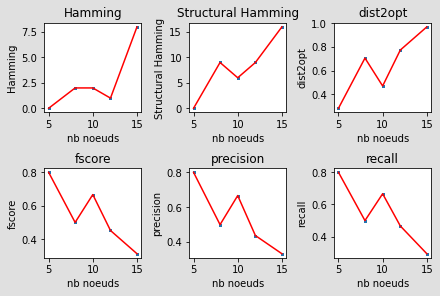

In [14]:
def tests_bn_vs_bn_enFontion_nbNoeud(Algo):
    nb_apprentissage_par_n_nodes=100
    criteres_all=[]
    list_nb_nodes=[5,8,10,12,15]
    n=5000

    for n_nodes in list_nb_nodes:
        n_arcs=int(1.25*n_nodes)
        bn_original=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
        for _ in range(nb_apprentissage_par_n_nodes):
            oneBN_approx,_,_=Algo(bn_original,csvFilePath="test.csv",verbose=False,isTest=True)
            comparator=bn_vs_bn.GraphicalBNComparator(bn_original,oneBN_approx)
            #criteres=comparator.skeletonScores()
            criteres=comparator.scores()
            criteres.update(comparator.hamming())
            criteres["n_nodes"]=n_nodes
            criteres_all.append(criteres)

    bnx=[criteres["n_nodes"] for criteres in criteres_all]
    bny_hamming=[criteres["hamming"] for criteres in criteres_all]
    bny_StructuralHamming=[criteres["structural hamming"] for criteres in criteres_all]
    bny_precision=[criteres["precision"] for criteres in criteres_all]
    bny_recall=[criteres["recall"] for criteres in criteres_all]
    bny_fscore=[criteres["fscore"] for criteres in criteres_all]
    bny_dist2opt=[criteres["dist2opt"] for criteres in criteres_all]

    moy_all=dict()
    for name in ["hamming","structural hamming","precision","recall","fscore","dist2opt"]:
        list_moy_selon_nb_nodes=[]
        for n in list_nb_nodes:
            moy=0
            i=0
            for criteres in criteres_all:
                if(criteres["n_nodes"]==n):
                    moy+=criteres[name]
                    i+=1
            list_moy_selon_nb_nodes.append(moy/i)
        moy_all[name]=list_moy_selon_nb_nodes
    return bnx,bny_hamming,bny_StructuralHamming,bny_precision,bny_recall,bny_fscore,bny_dist2opt,moy_all,list_nb_nodes

def plot_tests_bn_vs_bn_enFontion_nbNoeud(bnx,bny_hamming,bny_StructuralHamming,bny_precision,bny_recall,bny_fscore,bny_dist2opt,moy_all,list_nb_nodes): 
    fig1, f1_axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True)
    f1_axes[0][0].scatter(bnx,bny_hamming,label="Hamming",s=3)
    f1_axes[0][0].set_title("Hamming")
    f1_axes[0][0].plot(list_nb_nodes,moy_all["hamming"],c='r',label="Hamming moyen")
    f1_axes[0][0].set_xlabel("nb noeuds")
    f1_axes[0][0].set_ylabel("Hamming")

    f1_axes[0][1].scatter(bnx,bny_StructuralHamming,label="Structural Hamming",s=3)
    f1_axes[0][1].set_title("Structural Hamming")
    f1_axes[0][1].plot(list_nb_nodes,moy_all["structural hamming"],c='r',label="Structural Hamming moyen")
    f1_axes[0][1].set_xlabel("nb noeuds")
    f1_axes[0][1].set_ylabel("Structural Hamming")

    f1_axes[0][2].scatter(bnx,bny_dist2opt,label="dist2opt",s=3)
    f1_axes[0][2].set_title("dist2opt")
    f1_axes[0][2].plot(list_nb_nodes,moy_all["dist2opt"],c='r',label="dist2opt moyen")
    f1_axes[0][2].set_xlabel("nb noeuds")
    f1_axes[0][2].set_ylabel("dist2opt")

    f1_axes[1][0].scatter(bnx,bny_fscore,label="fscore",s=3)
    f1_axes[1][0].set_title("fscore")
    f1_axes[1][0].plot(list_nb_nodes,moy_all["fscore"],c='r',label="fscore moyen")
    f1_axes[1][0].set_xlabel("nb noeuds")
    f1_axes[1][0].set_ylabel("fscore")

    f1_axes[1][1].scatter(bnx,bny_precision,label="precision",s=3)
    f1_axes[1][1].set_title("precision")
    f1_axes[1][1].plot(list_nb_nodes,moy_all["precision"],c='r',label="precision moyen")
    f1_axes[1][1].set_xlabel("nb noeuds")
    f1_axes[1][1].set_ylabel("precision")

    f1_axes[1][2].scatter(bnx,bny_recall,label="recall",s=3)
    f1_axes[1][2].set_title("recall")
    f1_axes[1][2].plot(list_nb_nodes,moy_all["recall"],c='r',label="recall moyen")
    f1_axes[1][2].set_xlabel("nb noeuds")
    f1_axes[1][2].set_ylabel("recall")

    plt.show()

plot_tests_bn_vs_bn_enFontion_nbNoeud(*tests_bn_vs_bn_enFontion_nbNoeud(learn_PC))

### 1.2.4 Test Structural Hamming, F-score, dist2opt en fonction du nombre de particules
- nb_noeuds = entier entre 5 et 10
- nb_arcs=1.25*nb_noeuds

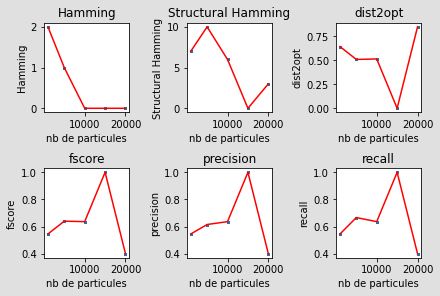

In [15]:
def tests_bn_vs_bn_enFontion_nbParticules(Algo):
    nb_apprentissage_par_n_particules=100
    criteres_all=[]
    list_nb_particules=[1000,5000,10000,15000,20000]
    for n in list_nb_particules:
        n_nodes=random.randint(5,10)
        n_arcs=int(1.25*n_nodes)
        bn_original=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
        for _ in range(nb_apprentissage_par_n_particules):
            oneBNApprox,_,_=Algo(bn_original,csvFilePath="test.csv",verbose=False,isTest=True)
            # if len(bn_approx_all)==0:
            #     continue
            comparator=bn_vs_bn.GraphicalBNComparator(bn_original,oneBNApprox)
            #criteres=comparator.skeletonScores()
            criteres=comparator.scores()
            criteres.update(comparator.hamming())
            criteres["nb_particules"]=n
            criteres_all.append(criteres)

    bnx=[criteres["nb_particules"] for criteres in criteres_all]
    bny_hamming=[criteres["hamming"] for criteres in criteres_all]
    bny_StructuralHamming=[criteres["structural hamming"] for criteres in criteres_all]
    bny_precision=[criteres["precision"] for criteres in criteres_all]
    bny_recall=[criteres["recall"] for criteres in criteres_all]
    bny_fscore=[criteres["fscore"] for criteres in criteres_all]
    bny_dist2opt=[criteres["dist2opt"] for criteres in criteres_all]

    moy_all=dict()
    for name in ["hamming","structural hamming","precision","recall","fscore","dist2opt"]:
        list_moy_selon_nb_particules=[]
        for n in list_nb_particules:
            moy=0
            i=0
            for criteres in criteres_all:
                if(criteres["nb_particules"]==n):
                    moy+=criteres[name]
                    i+=1
            list_moy_selon_nb_particules.append(moy/i)
        moy_all[name]=list_moy_selon_nb_particules
    return bnx,bny_hamming,bny_StructuralHamming,bny_precision,bny_recall,bny_fscore,bny_dist2opt,moy_all,list_nb_particules
def plot_tests_bn_vs_bn_enFontion_nbParticules(bnx,bny_hamming,bny_StructuralHamming,bny_precision,bny_recall,bny_fscore,bny_dist2opt,moy_all,list_nb_particules):    
    fig1, f1_axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True)
    f1_axes[0][0].scatter(bnx,bny_hamming,label="Hamming",s=3)
    f1_axes[0][0].set_title("Hamming")
    f1_axes[0][0].plot(list_nb_particules,moy_all["hamming"],c='r',label="Hamming moyen")
    f1_axes[0][0].set_xlabel("nb de particules")
    f1_axes[0][0].set_ylabel("Hamming")

    f1_axes[0][1].scatter(bnx,bny_StructuralHamming,label="Structural Hamming",s=3)
    f1_axes[0][1].set_title("Structural Hamming")
    f1_axes[0][1].plot(list_nb_particules,moy_all["structural hamming"],c='r',label="Structural Hamming moyen")
    f1_axes[0][1].set_xlabel("nb de particules")
    f1_axes[0][1].set_ylabel("Structural Hamming")

    f1_axes[0][2].scatter(bnx,bny_dist2opt,label="dist2opt",s=3)
    f1_axes[0][2].set_title("dist2opt")
    f1_axes[0][2].plot(list_nb_particules,moy_all["dist2opt"],c='r',label="dist2opt moyen")
    f1_axes[0][2].set_xlabel("nb de particules")
    f1_axes[0][2].set_ylabel("dist2opt")

    f1_axes[1][0].scatter(bnx,bny_fscore,label="fscore",s=3)
    f1_axes[1][0].set_title("fscore")
    f1_axes[1][0].plot(list_nb_particules,moy_all["fscore"],c='r',label="fscore moyen")
    f1_axes[1][0].set_xlabel("nb de particules")
    f1_axes[1][0].set_ylabel("fscore")

    f1_axes[1][1].scatter(bnx,bny_precision,label="precision",s=3)
    f1_axes[1][1].set_title("precision")
    f1_axes[1][1].plot(list_nb_particules,moy_all["precision"],c='r',label="precision moyen")
    f1_axes[1][1].set_xlabel("nb de particules")
    f1_axes[1][1].set_ylabel("precision")

    f1_axes[1][2].scatter(bnx,bny_recall,label="recall",s=3)
    f1_axes[1][2].set_title("recall")
    f1_axes[1][2].plot(list_nb_particules,moy_all["recall"],c='r',label="recall moyen")
    f1_axes[1][2].set_xlabel("nb de particules")
    f1_axes[1][2].set_ylabel("recall")

    plt.show()

plot_tests_bn_vs_bn_enFontion_nbParticules(*tests_bn_vs_bn_enFontion_nbParticules(learn_PC))

# 2. Algorithme PC-Stable

In [6]:
#Fonction d'apprentissage avec PC-Stable, retourne tous les BN issus du graphe essentiel

#Fonction d'apprentissage avec PC-STABLE, retourne tous les BN issus du graphe essentiel
def learn_PC_STABLE(bn,csvFilePath="test.csv",verbose=False,isTest=False,nivRisque=0.05):
    """Approxime un BN à partir de particules données à travers un CSV donné.

    Parameters
    ----------
    csvFilePath : str, optional
        chemin vers le fichier CSV, by default "test.csv"
    verbose : bool, optional
        Permet d'afficher le graphe mixte au cours de l'apprentissage et le BN approximé à la fin avec le BN utilisé pour 
        générer les particules, by default False

    Returns
    -------
    pyAgrum.BayesNet
        Une approximation du BN qui a généré les particules
    """
    start=time.time()
    Algo_PC_STABLE=PC(csvFilePath=csvFilePath)
    if verbose:
        print("######################## Apprentissage avec PC-STABLE ########################\n")
        GNonOriente=gum.MixedGraph(Algo_PC_STABLE.G)
    #GNonOriente=gum.MixedGraph(Algo_PC_STABLE.G)

    Algo_PC_STABLE.phase1_STABLE(nivRisque=nivRisque)
    if verbose:
        GPhase1=gum.MixedGraph(Algo_PC_STABLE.G)
    #GPhase1=gum.MixedGraph(Algo_PC_STABLE.G)
    Algo_PC_STABLE.phase2()
    end=time.time()
    duration=end-start
    
    if (not isTest):
        all_bnApprox=get_approxBN(bn,Algo_PC_STABLE)
    if (isTest):
        oneBN=getOneApproxBN(bn,Algo_PC_STABLE)

    if verbose:
        GPhase21=Algo_PC_STABLE.GPhase21
        GPhase2=gum.MixedGraph(Algo_PC_STABLE.G)
        s='s' if duration>1 else ""
        print(f"Apprentissage en {duration} seconde{s} avec {Algo_PC_STABLE.learner.nbRows()} particules générées à partir d'un BN avec {len(bn.nodes())} noeuds, {len(bn.arcs())} arcs et de modalité maximum {bn.maxVarDomainSize()} ")
        print("Graphe 1 : non orienté complet ------ Graphe 2 : après phase 1 ------ Graphe 3 : après phase 2.1 ------ Graphe 4 : après phase 2.2")
        gnb.sideBySide(GNonOriente,GPhase1,GPhase21,GPhase2)
        if(not isTest):
            print("1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC")
            gnb.sideBySide(bn,*all_bnApprox)
        if (isTest):
            print("1er BN = BN utilisé pour générer les particules ------ 2ème BN = un des BN possibles issus du graphe essentiel")
            gnb.sideBySide(bn,oneBN)
    if (not isTest):
        return all_bnApprox,duration,Algo_PC_STABLE
    if (isTest):
        return oneBN,duration,Algo_PC_STABLE

## 2.1 Exemple d'utilisation

In [50]:
bn=genRandomBN()
bn_approx,duration,_=learn_PC_STABLE(bn,csvFilePath="test.csv",verbose=True,isTest=False)

######################## Apprentissage avec PC-STABLE ########################

Apprentissage en 0.0330049991607666 seconde avec 20000 particules générées à partir d'un BN avec 5 noeuds, 4 arcs et de modalité maximum 4 
Graphe 1 : non orienté complet ------ Graphe 2 : après phase 1 ------ Graphe 3 : après phase 2.1 ------ Graphe 4 : après phase 2.2


no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 1->2 --> 1->2 <!-- 1->3 --> 1->3 <!-- 1->4 --> 1->4 <!-- 2->3 --> 2->3 <!-- 2->4 --> 2->4 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 1 --> 1 1 <!-- 1->2 --> 1->2 <!-- 4 --> 4 4 <!-- 2->4 --> 2->4 <!-- 3 --> 3 3 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 1 --> 1 1 <!-- 1->2 --> 1->2 <!-- 4 --> 4 4 <!-- 2->4 --> 2->4 <!-- 3 --> 3 3 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 1 --> 1 1 <!-- 1->2 --> 1->2 <!-- 4 --> 4 4 <!-- 2->4 --> 2->4 <!-- 3 --> 3 3 <!-- 3->4 --> 3->4


1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC


G <!-- n_3 --> n_3 n_3 <!-- n_4 --> n_4 n_4 <!-- n_3->n_4 --> n_3->n_4 <!-- n_0 --> n_0 n_0 <!-- n_2 --> n_2 n_2 <!-- n_0->n_2 --> n_0->n_2 <!-- n_2->n_4 --> n_2->n_4 <!-- n_1 --> n_1 n_1 <!-- n_2->n_1 --> n_2->n_1,G <!-- n_3 --> n_3 n_3 <!-- n_4 --> n_4 n_4 <!-- n_3->n_4 --> n_3->n_4 <!-- n_0 --> n_0 n_0 <!-- n_2 --> n_2 n_2 <!-- n_0->n_2 --> n_0->n_2 <!-- n_2->n_4 --> n_2->n_4 <!-- n_1 --> n_1 n_1 <!-- n_1->n_2 --> n_1->n_2,G <!-- n_3 --> n_3 n_3 <!-- n_4 --> n_4 n_4 <!-- n_3->n_4 --> n_3->n_4 <!-- n_0 --> n_0 n_0 <!-- n_2 --> n_2 n_2 <!-- n_0->n_2 --> n_0->n_2 <!-- n_2->n_4 --> n_2->n_4 <!-- n_1 --> n_1 n_1 <!-- n_2->n_1 --> n_2->n_1,G <!-- n_3 --> n_3 n_3 <!-- n_4 --> n_4 n_4 <!-- n_3->n_4 --> n_3->n_4 <!-- n_0 --> n_0 n_0 <!-- n_2 --> n_2 n_2 <!-- n_2->n_0 --> n_2->n_0 <!-- n_2->n_4 --> n_2->n_4 <!-- n_1 --> n_1 n_1 <!-- n_1->n_2 --> n_1->n_2,G <!-- n_3 --> n_3 n_3 <!-- n_4 --> n_4 n_4 <!-- n_3->n_4 --> n_3->n_4 <!-- n_0 --> n_0 n_0 <!-- n_2 --> n_2 n_2 <!-- n_2->n_0 --> n_2->n_0 <!-- n_2->n_4 --> n_2->n_4 <!-- n_1 --> n_1 n_1 <!-- n_2->n_1 --> n_2->n_1


## 2.2 Analyse Expérimentale de PC-Stable

### 2.2.1 Test du temps d'execution moyen pour des BN en fonction du nombre de particules dans le CSV
- n_nodes = entier entre 5 et 10
- n_arcs=1.25*n_nodes

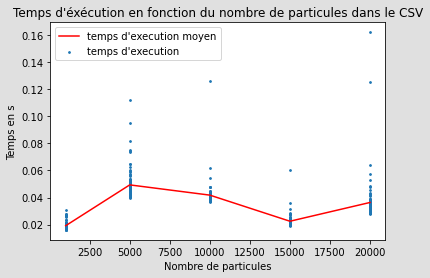

In [52]:
plot_testTempsExec_EnFonction_NbParticules(*testTempsExec_EnFonction_NbParticules(learn_PC_STABLE))

### 2.2.2 Test du temps d'execution moyen pour des BN en fonction du nombre noeuds dans le BN
- CSV = 5000 particules
- nb_arcs=1.25*nb_noeuds

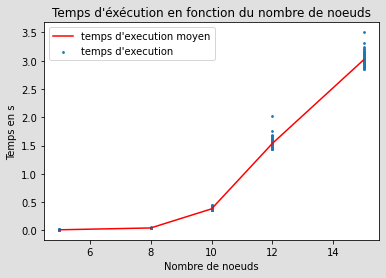

In [54]:
plot_testTempsExec_enFonction_nbNoeuds(*testTempsExec_enFonction_nbNoeuds(learn_PC_STABLE))

### 2.2.3 Test Structural Hamming, F-score, dist2opt en fonction du nombre de noeuds dans un BN
- CSV = 5000 particules

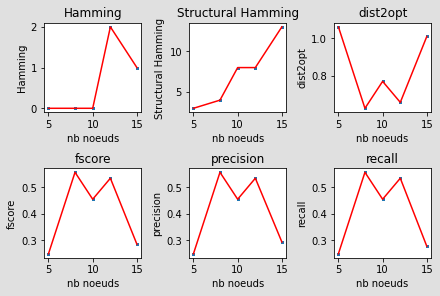

In [16]:
plot_tests_bn_vs_bn_enFontion_nbNoeud(*tests_bn_vs_bn_enFontion_nbNoeud(learn_PC_STABLE))

### 2.2.4 Test Structural Hamming, F-score, dist2opt en fonction du nombre de particules
- nb_noeuds = entier entre 5 et 10
- nb_arcs=1.25*nb_noeuds

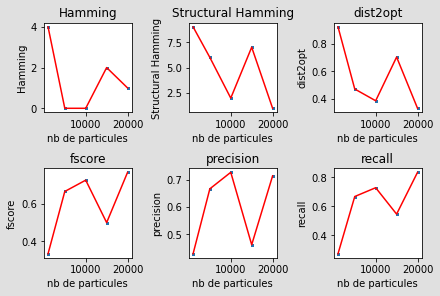

In [17]:
plot_tests_bn_vs_bn_enFontion_nbParticules(*tests_bn_vs_bn_enFontion_nbParticules(learn_PC_STABLE))

# Bonus

In [3]:
def G_Equals(G1,G2):
    if(len(G1.nodes())==len(G2.nodes())):
        for edge in G1.edges():
            if edge not in G2.edges():
                return False
        for arc in G1.arcs():
            if arc not in G2.arcs():
                return False
        return True
    else:
        return False
def G_Union(listG):
    G=gum.MixedGraph()
    for G_k in listG:
        for (x,y) in G_k.edges():
            if(not G.existsEdge((x,y))):
                G.addEdge((x,y))
            if(G.existsArc((x,y))):
                G.eraseArc((x,y))
            if(G.existsArc((y,x))):
                G.eraseArc((y,x))
        for (x,y) in G_k.arcs():
            if(G.existsEdge((x,y))):
                continue
            if(not G.existsArc((x,y))):
                G.addArc((x,y))
            if(G.existsArc((y,x))):
                G.eraseArc((y,x))
                G.addEdge((x,y))
    return G
            

def learn_PC_CSS_Version1(bn,csvFilePath="test.csv",verbose=False,isTest=False,nivRisque=0.05):
    start=time.time()
    Algo_PC_CSS_Version1=PC(csvFilePath=csvFilePath)
    if verbose:
        print("######################## Apprentissage avec PC_CSS_Version1 ########################\n")
    Algo_PC_CSS_Version1.phase1_PC_CSS(nivRisque=nivRisque,G1=Algo_PC_CSS_Version1.G,G2=gum.MixedGraph())
    G0=gum.MixedGraph(Algo_PC_CSS_Version1.G)
    Gk_moins_1=gum.MixedGraph(Algo_PC_CSS_Version1.G)
    allGs=[G0]
    DoesContinue=True
    k=0
    while(DoesContinue):
        k+=1
        Algo_PC_CSS_Version1.phase1_PC_CSS(nivRisque=nivRisque,G1=G0,G2=Gk_moins_1)
        Algo_PC_CSS_Version1.phase2_PC_CSS()
        Gk_moins_1=gum.MixedGraph(Algo_PC_CSS_Version1.G)
        allGs.append(Gk_moins_1)
        #ConditionArret
        for i in range(k):
            if(G_Equals(allGs[k-i],allGs[k])):
                DoesContinue=False
                break
    G_final=G_Union([allGs[g] for g in range(k-i,k+1)])
    Algo_PC_CSS_Version1.G=G_final
    end=time.time()
    duration=end-start
    
    if (not isTest):
        all_bnApprox=get_approxBN(bn,Algo_PC_CSS_Version1)
    if (isTest):
        oneBN=getOneApproxBN(bn,Algo_PC_CSS_Version1)

    if verbose:
        s='s' if duration>1 else ""
        print(f"Apprentissage en {duration} seconde{s} avec {Algo_PC_CSS_Version1.learner.nbRows()} particules générées à partir d'un BN avec {len(bn.nodes())} noeuds, {len(bn.arcs())} arcs et de modalité maximum {bn.maxVarDomainSize()} ")
        print("Graphe 1 : non orienté complet ------ Graphe 2 : après phase 1 ------ Graphe 3 : après phase 2.1 ------ Graphe 4 : après phase 2.2")
        if(not isTest):
            print("1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC")
            gnb.sideBySide(bn,*all_bnApprox)
        if (isTest):
            print("1er BN = BN utilisé pour générer les particules ------ 2ème BN = un des BN possibles issus du graphe essentiel")
            gnb.sideBySide(bn,oneBN)
    if (not isTest):
        return all_bnApprox,duration,Algo_PC_CSS_Version1
    if (isTest):
        return oneBN,duration,Algo_PC_CSS_Version1

In [4]:
bn=genRandomBN()
bn_approx,duration,_=learn_PC_CSS_Version1(bn,csvFilePath="test.csv",verbose=True,isTest=False)

######################## Apprentissage avec PC_CSS_Version1 ########################



TypeError: 'SwigPyObject' object is not iterable